<font size=5  color=#003366> [LINMA2472] - Algorithms in Data Science <br>
Project 1: Networks </font> <br><br>
<font size=3  color=#003366>  Students: Iacopo Canetta, Giovanni Faldani
<br><br>

- <font size=4  color=#003366>Task 1: building the co-occurence network of characters </font> <br><br>
In this project we'll build a graph network representing the bonds between characters present in the classical novel "The Betrothed" by Alessandro Manzoni

In [13]:
# basic imports
import numpy as np
import pandas as pd # useful dataframe support
import scipy as sp
from matplotlib import pyplot as plt # plot operations
import networkx as nx # useful for network operations
import nltk # useful for sentence parsing
import re # regular expressions for text parsing and finding proper names
import networkx.algorithms.community as nx_comm
import sklearn
from sklearn.cluster import SpectralClustering
import communities.algorithms as comm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Giovanni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# text file parsing
txt_filename = "./data/pg35155.txt"

text = []
with open(txt_filename, "r") as input_f:
    text = input_f.read()

# split text by paragraph

paragraphs = re.split("(?<!\")\n\n(?<!\")", text)#\n is the name for skipping to the next line
print("The text is composed of {} paragraphs!\n".format(len(paragraphs)))

# extract all individual sentences from a text
def sentences_in(text):
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

    sentences = sent_detector.tokenize(text.strip())
    return sentences

# extract all the dialogue within quotations in a text
def dialogue_in(text):
    return re.findall('"([^"]*)"', text)

# extract all words beginning with a capital letter in a text
def proper_names_in(text):
    return re.findall("[A-Z][a-z]+", text)

# test with a random paragraph
n = 75

print(paragraphs[n])
dialogues = dialogue_in(paragraphs[n])
sentences = sentences_in(paragraphs[n])
names = proper_names_in(paragraphs[n])
print("\nParagraph {} is composed of {} sentences, {} dialogues and {} proper names".format(
    n, len(sentences), len(dialogues), len(names)))
print(sentences[0])
print(dialogues[0])
print(names[0])

The text is composed of 1202 paragraphs!

From all that has been said, we may imagine the effect the meeting just
described must have had upon the mind of poor Don Abbondio. Those fierce
countenances, the threats of a lord who was well known not to speak
idly, his plan of quiet life and patient endurance disconcerted in an
instant, a difficulty before him from which he saw no possibility of
extrication; all these thoughts rushed confusedly through his mind. "If
Renzo could be quietly dismissed with a refusal, all would be well; but
he will require reasons--and what can I say to him? he too has a head of
his own; a lamb, if not meddled with--but once attempt to cross him----
Oh!--and raving after that Lucy, as much enamoured as---- Young idiots!
who, for want of something else to do, fall in love, and must be
married, forsooth, thinking of nothing else, never concerning themselves
about the trouble they bring upon an honest man like me. Wretch that I
am! Why should those two scowling fa

- As we can see finding the proper names of characters is no easy task, so we decided to rely on an external list of characters to look for matches and build our graph.

In [3]:
# let's list all the proper names in the book. This might take a while...
allNames = set(proper_names_in(text))
print(allNames)
# need to make a decision here

{'Street', 'Agreed', 'Additional', 'Fly', 'Away', 'Satisfied', 'Provincial', 'And', 'Spaniard', 'Faith', 'Perceiving', 'Overcome', 'Email', 'Balobbio', 'Drink', 'For', 'Pale', 'Aimwell', 'Into', 'Done', 'Victor', 'Notwithstanding', 'Garbugli', 'Answer', 'Martha', 'Different', 'If', 'Gentlemen', 'Weeds', 'By', 'Carlos', 'Biron', 'Overpowerful', 'Has', 'Trust', 'Hang', 'True', 'Redistributing', 'Lara', 'Supper', 'Gospel', 'Yesterday', 'Abandon', 'Persian', 'Ambrosio', 'Online', 'Hereupon', 'Fled', 'Reproach', 'Provisions', 'Prepare', 'Resegone', 'Attacked', 'Statista', 'Renzo', 'Put', 'Add', 'Crr', 'Write', 'Gently', 'Carlandrea', 'Berlinghe', 'Vanilla', 'Royal', 'Politeness', 'Nassau', 'Cousin', 'March', 'Easy', 'Giustizia', 'Strange', 'Fright', 'Such', 'Intently', 'Pentecost', 'Nevertheless', 'Father', 'Christina', 'Finding', 'Burgeto', 'Marrados', 'Pretty', 'Louis', 'Cedant', 'Throw', 'Directly', 'Rascals', 'Betrothed', 'Bravo', 'Bouillon', 'Learn', 'Once', 'Besides', 'Blessed', 'Ripa

In [4]:
#open character list
txt_filename = "./data/CharacterList.txt"

characterList = []
with open(txt_filename, "r") as input_f:
    characterList = input_f.read()

#parsing characterlist and counting them
mainCharacters = re.split("\n", characterList)
totalCharacters = len(mainCharacters)
print(mainCharacters)

# making dictionary of associations {graph node : character}
nodeCharacter = dict()
for i in range(len(mainCharacters)):
    nodeCharacter[i] = mainCharacters[i]
    
print("\n Node associations: ", nodeCharacter)

['Abbondio', 'Perpetua', 'Renzo', 'Lucy', 'Agnes', 'Azzecca', 'Christopher', 'Roderick', 'Griso', 'Gertrude', 'Attilio', 'Tony', 'Jervase', 'Ferrer', 'Rivolta', 'Alessio', 'Menico', 'Egidio', 'Nibbio', 'Bortolo', 'Federigo', 'Prassede', 'Ferrante', 'Galdino', 'Unknown', 'Richelieu', 'Beppo', 'Anselmo', 'Gonzalo', 'Carlos', 'Margherita']

 Node associations:  {0: 'Abbondio', 1: 'Perpetua', 2: 'Renzo', 3: 'Lucy', 4: 'Agnes', 5: 'Azzecca', 6: 'Christopher', 7: 'Roderick', 8: 'Griso', 9: 'Gertrude', 10: 'Attilio', 11: 'Tony', 12: 'Jervase', 13: 'Ferrer', 14: 'Rivolta', 15: 'Alessio', 16: 'Menico', 17: 'Egidio', 18: 'Nibbio', 19: 'Bortolo', 20: 'Federigo', 21: 'Prassede', 22: 'Ferrante', 23: 'Galdino', 24: 'Unknown', 25: 'Richelieu', 26: 'Beppo', 27: 'Anselmo', 28: 'Gonzalo', 29: 'Carlos', 30: 'Margherita'}


In [5]:
#cleans a list of characters !!!TODO eliminate duplicates
def clean_names(characterList, mainCharacters):
    for character in list(characterList):
        if character not in mainCharacters:
            characterList.remove(character)
            
    
#iterate over cleant list and updates matrix (lamest optimization ever)
def update_matrix(characterList, mainCharacters, matrix):
    if len(characterList) < 2:
        return
    
    for i in range(len(characterList)):
        currentCharacterIndex = mainCharacters.index(characterList[i])
        for j in range(len(characterList) - i - 1):
            secondCharacterIndex = mainCharacters.index(characterList[j + i + 1])
            matrix[currentCharacterIndex][secondCharacterIndex] += 1;
            matrix[secondCharacterIndex][currentCharacterIndex] += 1;
            
            

#matrix totalCharacters * totalCharacters initialized with all 0s
adjacencyMatrix = [[0 for _ in range(totalCharacters)] for _ in range(totalCharacters)]

#iterate over paragraphs and get proper names
for i in range(len(paragraphs)):
    paragraphCharacters = proper_names_in(paragraphs[i])
    paragraphCharacters = list( dict.fromkeys(paragraphCharacters))
    clean_names(paragraphCharacters, mainCharacters)
    update_matrix(paragraphCharacters, mainCharacters, adjacencyMatrix)
    
print(adjacencyMatrix)


#print(adjacencyMatrix)

[[0, 35, 30, 31, 27, 1, 4, 15, 2, 0, 1, 4, 3, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 23, 0, 1, 1, 1, 1, 0], [35, 0, 10, 14, 17, 0, 2, 5, 2, 0, 1, 8, 4, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 7, 0, 1, 1, 0, 1, 0], [30, 10, 0, 107, 64, 4, 35, 27, 2, 1, 3, 12, 7, 8, 3, 3, 4, 0, 0, 6, 0, 4, 2, 1, 1, 0, 0, 0, 3, 0, 0], [31, 14, 107, 0, 87, 3, 36, 28, 6, 4, 4, 8, 5, 1, 2, 3, 3, 2, 6, 3, 0, 13, 6, 3, 21, 0, 0, 0, 0, 0, 0], [27, 17, 64, 87, 0, 2, 27, 14, 5, 0, 2, 5, 3, 1, 2, 2, 5, 0, 0, 3, 0, 6, 5, 4, 8, 0, 1, 1, 0, 0, 0], [1, 0, 4, 3, 2, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4, 2, 35, 36, 27, 1, 0, 17, 0, 0, 6, 0, 0, 0, 1, 1, 4, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0], [15, 5, 27, 28, 14, 2, 17, 0, 18, 0, 20, 1, 1, 1, 1, 0, 2, 2, 3, 1, 1, 0, 2, 1, 8, 1, 0, 0, 0, 0, 0], [2, 2, 2, 6, 5, 0, 0, 18, 0, 0, 5, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 

- Making the graph

Graph with 31 nodes and 153 edges


C:\Users\Giovanni\AppData\Local\Temp\ipykernel_920\2792126070.py:20: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


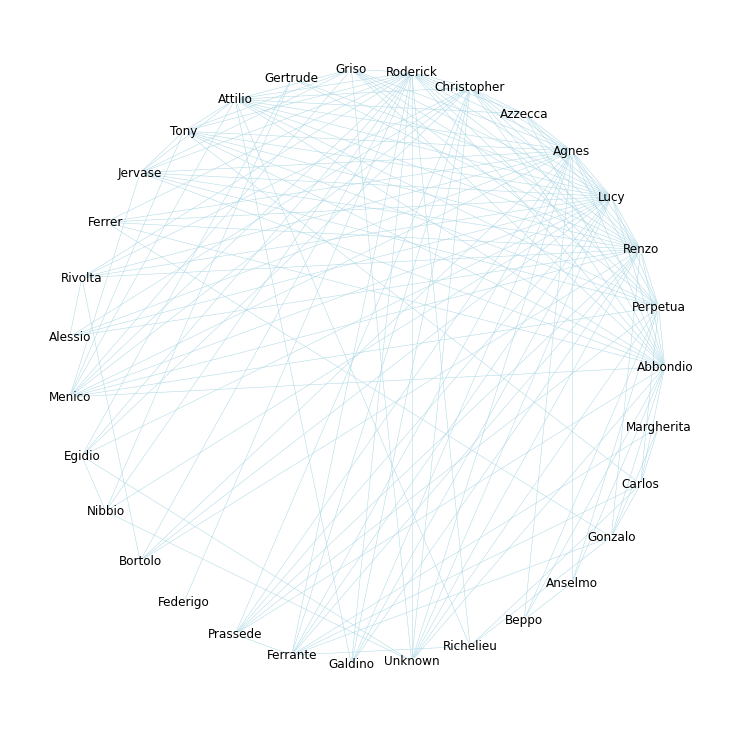

In [6]:
G = nx.Graph()

# add one node per character
for i in range(len(mainCharacters)):
    G.add_node(i, size = 1)
    
    
# add node labels
nx.set_node_attributes(G, nodeCharacter, name='Names')

# add the edges from the adjacency matrix (avoid duplicates)

for i in range(len(adjacencyMatrix)-1):
    for j in range(i+1, len(adjacencyMatrix[0])):
        if adjacencyMatrix[i][j] != 0 :
            G.add_edge(i,j, weight = adjacencyMatrix[i][j])
    
    
    
print(nx.info(G))
#print(G.nodes[0][""])

def print_graph(G):
    g_draw = G

    fig = plt.figure(figsize=(10,10))
    pos = nx.circular_layout(g_draw)
    nx.draw(g_draw, pos, node_color='white', edge_color='lightblue', node_size=50, labels = nx.get_node_attributes(G, 'Names'), with_labels = True, width=0.5)
    plt.show()
    
print_graph(G)

<font size=4> Preliminary observations about the graph: </font>

- Graph shape





- Degree assortativity: disassortative network

In [7]:
def  find_assortativity(graph):
    return nx.degree_assortativity_coefficient(graph)

assortativity = find_assortativity(G)
print(assortativity)

-0.2790477583432998


- Community detection with Louvain algorithm and Spectral clustering

In [14]:
#Louvain algorithm

communities1 = nx_comm.louvain_communities(G)
print("Louvain algo detected: ", communities1)

# Spectral clustering

# TODO Compute Laplacian matrix and set k to the number of eigenvalues "close" to zero -> optmal k
k=4

npMat = np.array([np.array(row) for row in adjacencyMatrix])
communities2 = comm.spectral_clustering(npMat, k)
print("Spectral Clustering algo detected: ", communities2)
# first compute laplacian matrix


Louvain algo detected:  [{2, 3, 4, 5, 6, 13, 14, 15, 19, 21, 23}, {7, 8, 9, 10, 16, 17, 18, 20}, {0, 1, 24, 27, 26, 11, 12}, {22, 25, 28, 29, 30}]
Spectral Clustering algo detected:  [{0, 1, 2, 3, 4, 6, 8, 11, 12, 16, 21, 24}, {20, 22, 25, 26, 27, 28, 29, 30}, {5, 7, 8, 9, 10, 13, 14, 15, 17, 18, 19, 21, 23}, {13, 21, 22, 25, 28, 29}]


- Comparison of the two methods

- Comparison of the two methods<font size=4> Influence maximization problem </font>